In [1]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## 读取数据并提取json列

In [2]:
data_bas=pd.read_csv('E:\\201810\\WuHui\\gjp_gmv_new3.csv')

myjson=data_bas['dict_months_gmv']
data_bas['idd']=np.arange(len(myjson))
data_bas['num1']=1
data_bas.head()

,user_id,transport_id,shop_num,summary_id,request_sids,platform_type,status_id,gmv_weighted,dict_months_gmv,use_month,created_date,updated_date,idd,num1
0,219472,192163,1,1641429,[1504468],GJP,4,6.875654e+05,"{""2016-11"": {""fyjc_amt"": 0, ""item_total_gmv"": ...",40,2017-11-28,2017-11-28,0,1
1,415176,193856,1,1902444,[1515122],GJP,4,3.192361e+05,"{""2017-11"": {""fyjc_amt"": 0, ""item_total_gmv"": ...",64,2018-11-20,2018-11-20,1,1
2,415340,193983,1,1515891,[1515891],GJP,4,1.496012e+06,"{""2016-07"": {""fyjc_amt"": 0, ""item_total_gmv"": ...",58,2017-07-03,2017-07-03,2,1
3,418620,195758,1,1526824,[1526824],GJP,4,9.461229e+05,"{""2016-07"": {""fyjc_amt"": 0, ""item_total_gmv"": ...",20,2017-07-16,2017-07-16,3,1
4,419706,196373,1,1530628,[1530628],GJP,4,1.153278e+06,"{""2016-07"": {""fyjc_amt"": 0, ""item_total_gmv"": ...",33,2017-07-20,2017-07-20,4,1


In [3]:
# 去重 保证summary_id不重复
data_index=data_bas.groupby('summary_id',as_index=False).agg({'transport_id':max})
data_clean=pd.merge(data_bas,data_index,how='inner')

In [4]:
data=data_clean
data['idd']=np.arange(len(data_clean))
myjson=data['dict_months_gmv']

## 研究团队GMV算法 解释

#### item_gmv：  
基于销售商品详情、商品成本详情计算得到。  
会去掉大单；  
计算所有销售金额item_total_gmv；  
计算（销售与进货、库存）匹配得上的销售金额item_match_gmv。   
          
#### order_gmv：  
基于销售单退货单信息.  
order_gmv=销售|零售金额-退货金额。   

#### account_gmv:  
基于会计记账科目明细表。  
针对主营业务收入|营业收入|销售收入;  
account_gmv=增加金额之和-减少金额绝对值之和。  

## 研究json结构

In [5]:
mjs1=json.loads(myjson[2])
#mjs1

## 正式开始解析

In [6]:
## 提取 gmv_merge
idd=[]
mon=[]

account_gmv=[]
fyjc_amt=[]
gmv_merge=[]
item_match_amt_rate=[]
item_total_gmv=[]
order_gmv=[]

for i in np.arange(len(myjson)):
    mjs=json.loads(myjson[i])
    for key in mjs.keys():
        mjs2=mjs[key]
        idd.append((i))
        mon.append(key)
        account_gmv.append(mjs2['account_gmv'])
        fyjc_amt.append(mjs2['fyjc_amt'])
        gmv_merge.append(mjs2['gmv_merge'])
        item_match_amt_rate.append(mjs2['item_match_amt_rate'])
        item_total_gmv.append(mjs2['item_total_gmv'])
        order_gmv.append(mjs2['order_gmv'])
        

In [7]:
data_js=pd.DataFrame({'idd':idd,'mon':mon,'account_gmv':account_gmv,'fyjc_amt':fyjc_amt,'gmv_merge':gmv_merge,'item_match_amt_rate':item_match_amt_rate,'item_total_gmv':item_total_gmv,'order_gmv':order_gmv})
data_js['num']=1
data_js=data_js[['gmv_merge','item_total_gmv','order_gmv','account_gmv','item_match_amt_rate','fyjc_amt','mon','num','idd']]
#data_js.sort_values('idd',ascending=False)

Text(0.5,1,'管家婆GMV时间序列')

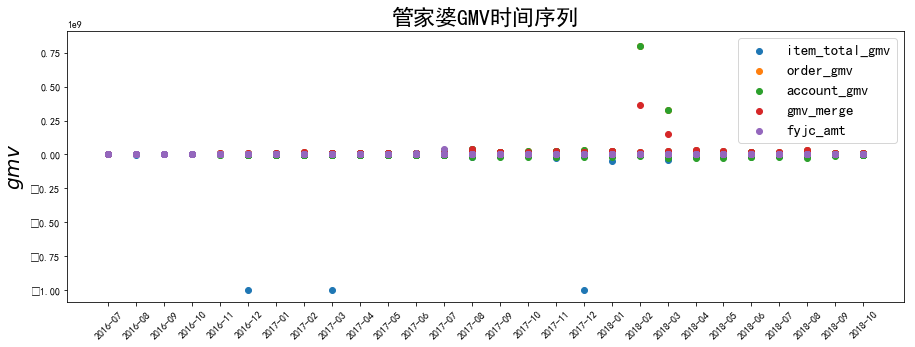

In [8]:
plt.rcParams['font.sans-serif']=['SimHei']

fig=plt.figure(figsize=(15,5))
ax1=fig.add_subplot(1,1,1)
ax1.scatter(data_js['mon'],data_js['item_total_gmv'],label='item_total_gmv')
ax1.scatter(data_js['mon'],data_js['order_gmv'],label='order_gmv')
ax1.scatter(data_js['mon'],data_js['account_gmv'],label='account_gmv')
ax1.scatter(data_js['mon'],data_js['gmv_merge'],label='gmv_merge')
ax1.scatter(data_js['mon'],data_js['fyjc_amt'],label='fyjc_amt')
#ax1.set_ylim(-50000000,50000000)
ax1.set_ylabel('$gmv$',size=20)
plt.legend(fontsize=15)
plt.xticks(rotation=45)
plt.title('管家婆GMV时间序列',size=22)

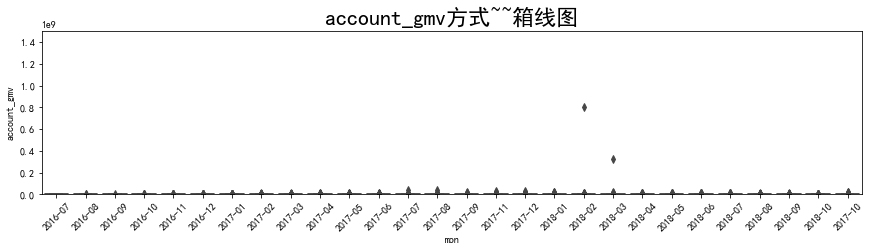

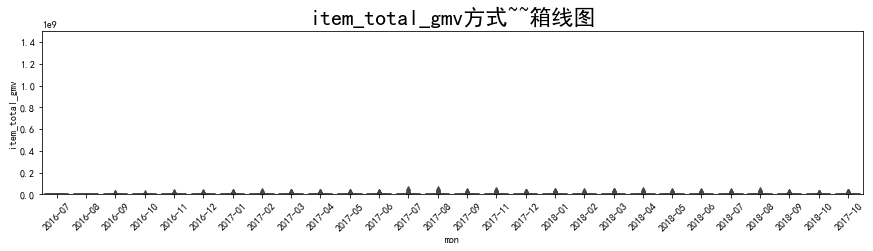

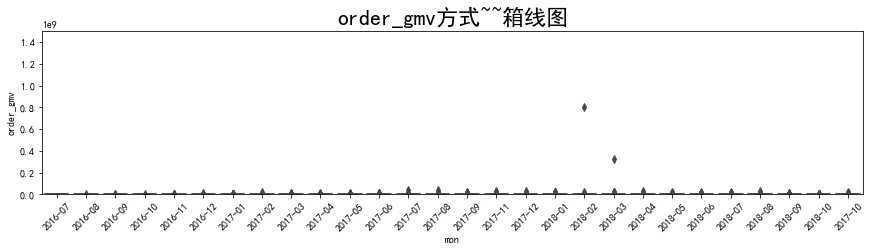

In [9]:
listt=['account_gmv','item_total_gmv','order_gmv']
for i in [0,1,2]:
    
    title=listt[i]  #account_gmv   item_total_gmv    order_gmv
    fig=plt.figure(figsize=(50,3))
    ax1=fig.add_subplot(1,3,i+1)
    sns.boxplot(data_js['mon'],data_js[title])   
    ax1.set_ylim(0,1500000000)
    plt.xticks(rotation=45)

    title_plus=title+'方式~~箱线图'
    plt.title(title_plus,size=22)

## 按实际经营月份聚合 看gmv

In [10]:
## 按实际经营月份聚合
grp_mon=data_js.groupby('mon',as_index=False).agg({'account_gmv':np.mean,'order_gmv':np.mean,'item_total_gmv':np.mean,'gmv_merge':np.mean,\
                               'fyjc_amt':np.mean,'item_match_amt_rate':np.mean,'num':sum})


#grp_mon
#grp_mon=grp_mon[grp_mon['mon']<'201811']

In [11]:
grp_mon

,mon,account_gmv,order_gmv,item_total_gmv,gmv_merge,fyjc_amt,item_match_amt_rate,num
0,2016-07,0.000000e+00,1.361576e+06,1.331773e+06,1.345320e+06,0.000000,0.795952,5
1,2016-08,4.212861e+05,8.784742e+05,7.336360e+05,8.118607e+05,0.000000,0.580318,12
2,2016-09,5.010659e+05,7.699039e+05,7.647978e+05,7.646490e+05,0.000000,0.672322,26
3,2016-10,4.856332e+05,7.262266e+05,7.030644e+05,7.003331e+05,0.000000,0.635794,36
4,2016-11,5.595208e+05,8.739699e+05,8.918146e+05,8.728134e+05,0.000000,0.655348,76
5,2016-12,4.862186e+05,7.824045e+05,-6.780066e+06,7.951386e+05,0.000000,0.579490,132
6,2017-01,3.861667e+05,7.715249e+05,7.942355e+05,7.877924e+05,0.000000,0.595972,186
7,2017-02,4.746899e+05,8.142663e+05,8.289321e+05,8.206781e+05,0.000000,0.649873,206
8,2017-03,5.711620e+05,9.675477e+05,-3.124301e+06,9.692713e+05,0.000000,0.667201,244
9,2017-04,4.612119e+05,8.343658e+05,8.513228e+05,8.449327e+05,0.000000,0.689416,296


Text(0.5,1,'管家婆GMV时间序列')

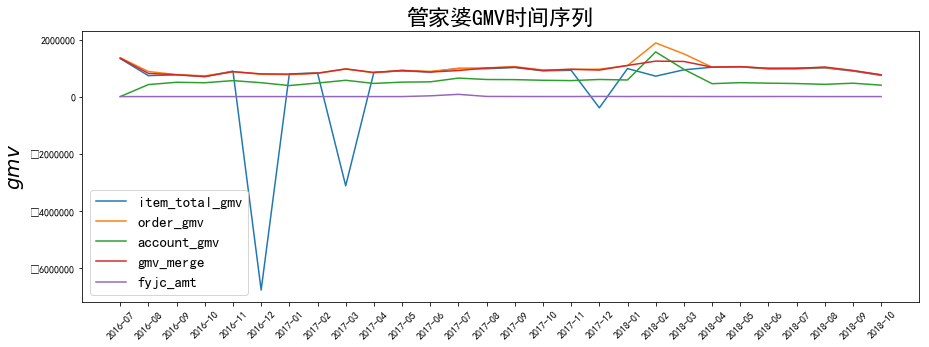

In [12]:
plt.rcParams['font.sans-serif']=['SimHei']

fig=plt.figure(figsize=(15,5))
ax1=fig.add_subplot(1,1,1)
ax1.plot(grp_mon['mon'],grp_mon['item_total_gmv'])
ax1.plot(grp_mon['mon'],grp_mon['order_gmv'])
ax1.plot(grp_mon['mon'],grp_mon['account_gmv'])
ax1.plot(grp_mon['mon'],grp_mon['gmv_merge'])
ax1.plot(grp_mon['mon'],grp_mon['fyjc_amt'])
#ax1.set_ylim(0,4500000)
ax1.set_ylabel('$gmv$',size=20)
plt.legend(['item_total_gmv','order_gmv','account_gmv','gmv_merge','fyjc_amt'],fontsize=15)
plt.xticks(rotation=45)
plt.title('管家婆GMV时间序列',size=22)

## 按客户聚合看gmv

In [13]:
## 按客户聚合
grp_customer=data_js.groupby('idd').agg({'account_gmv':np.mean,'order_gmv':np.mean,'item_total_gmv':np.mean,'gmv_merge':np.mean,\
                               'fyjc_amt':np.mean,'item_match_amt_rate':np.mean})
grp_customer

,account_gmv,order_gmv,item_total_gmv,gmv_merge,fyjc_amt,item_match_amt_rate
idd,,,,,,
0,9.411503e+03,1.703912e+06,1.704585e+06,1.495436e+06,0.0,0.978864
1,0.000000e+00,8.769280e+05,8.764947e+05,8.766916e+05,0.0,0.912294
2,0.000000e+00,1.162489e+06,1.161579e+06,1.161993e+06,0.0,0.998825
3,1.083750e+03,1.984136e+06,1.743006e+06,1.760625e+06,0.0,0.011598
4,0.000000e+00,4.821119e+05,4.787089e+05,4.802557e+05,0.0,0.967815
5,0.000000e+00,3.538884e+06,5.198512e+06,4.444136e+06,0.0,0.162066
6,3.596241e+03,8.025647e+05,8.036749e+05,7.366202e+05,0.0,0.991041
7,2.734379e+05,9.477532e+04,9.348805e+04,1.514016e+05,0.0,0.897011
8,3.833542e+03,1.598693e+06,1.626284e+06,1.330871e+06,0.0,0.000000


Text(0,0.5,'gmv_merge')

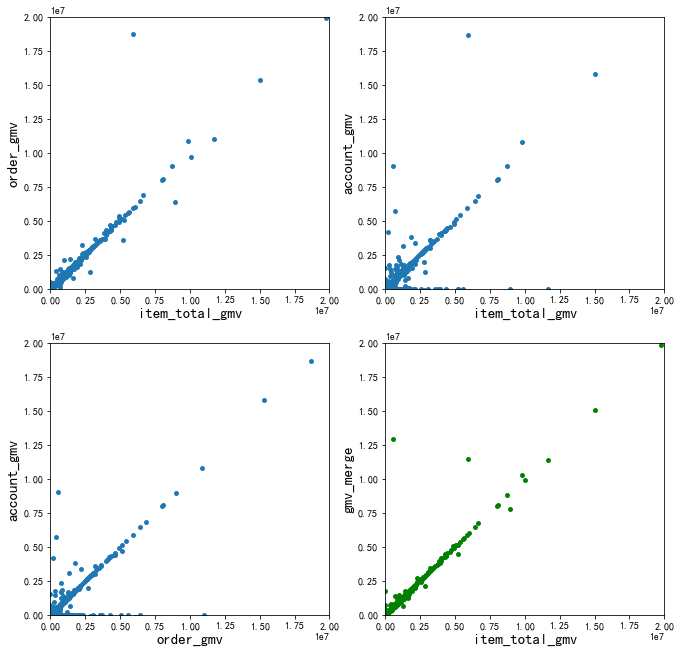

In [14]:
fig=plt.figure(figsize=(11,11))
ax1=fig.add_subplot(2,2,1)
ax1.scatter(grp_customer['item_total_gmv'],grp_customer['order_gmv'],s=15)
ax1.set_xlim(0,20000000)
ax1.set_ylim(0,20000000)
ax1.set_xlabel('item_total_gmv',size=15)
ax1.set_ylabel('order_gmv',size=15)

ax2=fig.add_subplot(2,2,2)
ax2.scatter(grp_customer['item_total_gmv'],grp_customer['account_gmv'],s=15)
ax2.set_xlim(0,20000000)
ax2.set_ylim(0,20000000)
ax2.set_xlabel('item_total_gmv',size=15)
ax2.set_ylabel('account_gmv',size=15)

ax3=fig.add_subplot(2,2,3)
ax3.scatter(grp_customer['order_gmv'],grp_customer['account_gmv'],s=15)
ax3.set_xlim(0,20000000)
ax3.set_ylim(0,20000000)
ax3.set_xlabel('order_gmv',size=15)
ax3.set_ylabel('account_gmv',size=15)

ax4=fig.add_subplot(2,2,4)
ax4.scatter(grp_customer['item_total_gmv'],grp_customer['gmv_merge'],s=15,c='green')
ax4.set_xlim(0,20000000)
ax4.set_ylim(0,20000000)
ax4.set_xlabel('item_total_gmv',size=15)
ax4.set_ylabel('gmv_merge',size=15)

## 3D图展示

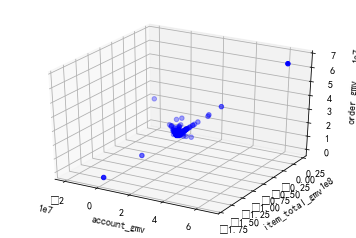

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ax = plt.subplot(111, projection='3d')  # 创建一个三维的绘图工程
ax.scatter(grp_customer['account_gmv'],grp_customer['item_total_gmv'],grp_customer['order_gmv'],c='b')  # 绘制数据点

ax.set_zlabel('order_gmv')  # 坐标轴
ax.set_ylabel('item_total_gmv')
ax.set_xlabel('account_gmv')
plt.show()

## 保存数据 转战Rstudio

In [16]:
grp_customer.to_csv('E:\\201810\\WuHui\\gjp_gmv_grp.csv')

## 特殊点分析
### type1 跳高

In [46]:
#sid=data_js[data_js['order_gmv']>0.25*100000000]
sid=data_js[data_js['order_gmv']/data_js['item_total_gmv']>=100]
sid

,gmv_merge,item_total_gmv,order_gmv,account_gmv,item_match_amt_rate,fyjc_amt,mon,num,idd
3239,1.490917e+08,599198.4375,3.272826e+08,3.272825e+08,1.001148,0.0,2018-03,1,269
7337,3.637190e+08,82620.0000,8.000826e+08,8.000825e+08,1.000000,0.0,2018-02,1,611
7584,7.200754e+05,0.0000,7.200754e+05,7.198954e+05,0.000000,0.0,2017-09,1,632
7585,6.119103e+05,0.0000,6.119103e+05,6.088243e+05,0.000000,0.0,2017-10,1,632
7586,4.634763e+05,0.0000,4.634763e+05,4.634764e+05,0.000000,0.0,2017-11,1,632
7587,2.965968e+05,0.0000,2.965968e+05,2.965968e+05,0.000000,0.0,2017-12,1,632
7588,3.014818e+05,0.0000,3.014818e+05,3.014818e+05,0.000000,0.0,2018-01,1,632
7589,1.031165e+05,0.0000,1.031165e+05,1.031165e+05,0.000000,0.0,2018-02,1,632
7590,6.708061e+05,0.0000,6.708061e+05,6.708061e+05,0.000000,0.0,2018-03,1,632
7591,5.788487e+05,0.0000,5.788487e+05,5.788487e+05,0.000000,0.0,2018-04,1,632


In [47]:
sid_summary_id=data[['idd','summary_id','transport_id']]
sid_look=pd.merge(sid,sid_summary_id,how='left',on='idd')
sid_look

,gmv_merge,item_total_gmv,order_gmv,account_gmv,item_match_amt_rate,fyjc_amt,mon,num,idd,summary_id,transport_id
0,1.490917e+08,599198.4375,3.272826e+08,3.272825e+08,1.001148,0.0,2018-03,1,269,1742775,235451
1,3.637190e+08,82620.0000,8.000826e+08,8.000825e+08,1.000000,0.0,2018-02,1,611,1835462,254151
2,7.200754e+05,0.0000,7.200754e+05,7.198954e+05,0.000000,0.0,2017-09,1,632,1841867,255306
3,6.119103e+05,0.0000,6.119103e+05,6.088243e+05,0.000000,0.0,2017-10,1,632,1841867,255306
4,4.634763e+05,0.0000,4.634763e+05,4.634764e+05,0.000000,0.0,2017-11,1,632,1841867,255306
5,2.965968e+05,0.0000,2.965968e+05,2.965968e+05,0.000000,0.0,2017-12,1,632,1841867,255306
6,3.014818e+05,0.0000,3.014818e+05,3.014818e+05,0.000000,0.0,2018-01,1,632,1841867,255306
7,1.031165e+05,0.0000,1.031165e+05,1.031165e+05,0.000000,0.0,2018-02,1,632,1841867,255306
8,6.708061e+05,0.0000,6.708061e+05,6.708061e+05,0.000000,0.0,2018-03,1,632,1841867,255306
9,5.788487e+05,0.0000,5.788487e+05,5.788487e+05,0.000000,0.0,2018-04,1,632,1841867,255306


### type2 负值

In [19]:
sid=data_js[data_js['item_total_gmv']<0]
sid.sort_values('item_total_gmv',ascending=True)

,gmv_merge,item_total_gmv,order_gmv,account_gmv,item_match_amt_rate,fyjc_amt,mon,num,idd
127,2.134883e+05,-9.997873e+08,2.135371e+05,2.134396e+05,0.0,0.0,2017-03,1,10
5825,4.490880e+05,-9.995508e+08,4.490880e+05,4.492730e+05,0.0,0.0,2017-12,1,485
124,7.214485e+05,-9.992803e+08,7.213985e+05,7.214985e+05,0.0,0.0,2016-12,1,10
4160,2.221410e+07,-5.178590e+07,2.221410e+07,2.221254e+07,0.0,0.0,2018-01,1,346
7542,1.306353e+06,-3.779183e+07,1.306353e+06,0.000000e+00,0.0,0.0,2018-03,1,628
8545,1.202503e+05,-2.419792e+07,1.202503e+05,1.202500e+05,0.0,0.0,2017-11,1,712
6756,4.866540e+05,-1.777308e+07,4.866540e+05,-1.874002e+07,0.0,0.0,2017-08,1,563
7540,5.066705e+05,-4.499104e+06,5.066705e+05,0.000000e+00,0.0,0.0,2018-01,1,628
798,1.390144e+06,-3.329916e+06,1.390144e+06,1.339467e+06,0.0,0.0,2017-05,1,66
4128,1.800674e+05,-3.325258e+06,1.800674e+05,3.511909e+05,0.0,0.0,2017-05,1,344


In [20]:
sid_summary_id=data[['idd','summary_id','transport_id','gmv_weighted']]

In [21]:
sid_look=pd.merge(sid,sid_summary_id,how='left',on='idd')

In [22]:
sid_look

,gmv_merge,item_total_gmv,order_gmv,account_gmv,item_match_amt_rate,fyjc_amt,mon,num,idd,summary_id,transport_id,gmv_weighted
0,3.419931e+05,-1.266458e+06,3.456811e+05,3.383051e+05,0.0,0.0,2016-08,1,10,1566801,202097,3.886873e+05
1,7.214485e+05,-9.992803e+08,7.213985e+05,7.214985e+05,0.0,0.0,2016-12,1,10,1566801,202097,3.886873e+05
2,2.134883e+05,-9.997873e+08,2.135371e+05,2.134396e+05,0.0,0.0,2017-03,1,10,1566801,202097,3.886873e+05
3,4.200000e+01,-5.593000e+03,4.200000e+01,4.200000e+01,0.0,0.0,2017-07,1,56,1636820,214246,2.622718e+06
4,0.000000e+00,-2.497422e+05,-2.525542e+05,-2.497422e+05,0.0,0.0,2017-01,1,57,1637642,214413,1.059711e+05
5,0.000000e+00,-2.763275e+04,-2.794534e+04,-2.755779e+04,0.0,0.0,2017-03,1,57,1637642,214413,1.059711e+05
6,0.000000e+00,-1.202025e+05,-1.193017e+05,-1.193017e+05,0.0,0.0,2017-04,1,57,1637642,214413,1.059711e+05
7,0.000000e+00,-5.944861e+04,-5.909859e+04,-5.944859e+04,0.0,0.0,2017-05,1,57,1637642,214413,1.059711e+05
8,0.000000e+00,-4.959028e+04,-4.959028e+04,-4.959028e+04,0.0,0.0,2017-08,1,57,1637642,214413,1.059711e+05
9,1.390144e+06,-3.329916e+06,1.390144e+06,1.339467e+06,0.0,0.0,2017-05,1,66,1638248,214519,1.263019e+06


In [23]:
data[data['idd']==775]

,user_id,transport_id,shop_num,summary_id,request_sids,platform_type,status_id,gmv_weighted,dict_months_gmv,use_month,created_date,updated_date,idd,num1
775,440223,261747,1,1892565,[1892565],GJP,4,5.003928e+06,"{""2017-11"": {""fyjc_amt"": 0, ""item_total_gmv"": ...",78,2018-11-01,2018-11-01,775,1


In [24]:
data[data['idd']==1355]

,user_id,transport_id,shop_num,summary_id,request_sids,platform_type,status_id,gmv_weighted,dict_months_gmv,use_month,created_date,updated_date,idd,num1


In [25]:
data_js[data_js['idd']==1355]

,gmv_merge,item_total_gmv,order_gmv,account_gmv,item_match_amt_rate,fyjc_amt,mon,num,idd


## 空值item_total_gmv

In [26]:
data_js[(data_js['item_total_gmv']==0) & (data_js['order_gmv']>0)]

,gmv_merge,item_total_gmv,order_gmv,account_gmv,item_match_amt_rate,fyjc_amt,mon,num,idd
7584,7.200754e+05,0.0,7.200754e+05,7.198954e+05,0.0,0.0,2017-09,1,632
7585,6.119103e+05,0.0,6.119103e+05,6.088243e+05,0.0,0.0,2017-10,1,632
7586,4.634763e+05,0.0,4.634763e+05,4.634764e+05,0.0,0.0,2017-11,1,632
7587,2.965968e+05,0.0,2.965968e+05,2.965968e+05,0.0,0.0,2017-12,1,632
7588,3.014818e+05,0.0,3.014818e+05,3.014818e+05,0.0,0.0,2018-01,1,632
7589,1.031165e+05,0.0,1.031165e+05,1.031165e+05,0.0,0.0,2018-02,1,632
7590,6.708061e+05,0.0,6.708061e+05,6.708061e+05,0.0,0.0,2018-03,1,632
7591,5.788487e+05,0.0,5.788487e+05,5.788487e+05,0.0,0.0,2018-04,1,632
7592,4.581459e+05,0.0,4.581459e+05,4.581459e+05,0.0,0.0,2018-05,1,632
7593,3.917244e+05,0.0,3.917244e+05,3.915644e+05,0.0,0.0,2018-06,1,632


In [27]:
data_js[data_js['idd']==1352]

,gmv_merge,item_total_gmv,order_gmv,account_gmv,item_match_amt_rate,fyjc_amt,mon,num,idd


## 导入gjp feature

In [28]:
dat_fe=pd.read_csv('E:\\201810\\WuHui\\gjp_feature.csv',encoding='gbk')

In [29]:
dat_fe

,transport_id,application_id,customer_name,gender,age,id_card_num,province,city,time_applied_at,apply_week,...,dataloan_score,amt_div_gmv,gmv_dataloan,flag_loan,amt_decision_w,amt_loan_w,apr_sum,MobDr1to3_od1,MobDr1to3_od30,MobDr1to6_od30
0,213572,227939,苏立文,男,39,332501197809011235,浙江,温州市,2017/11/17 11:32,2017/11/13,...,NaN,0.000000,3.055065,0,NaN,NaN,NaN,NaN,NaN,NaN
1,215035,229401,王迎炜,男,41,352230197609020013,广东,东莞市,2017/11/28 13:05,2017/11/27,...,NaN,0.161815,247.196601,0,40.0,4.4935,94.902720,0.0,0.0,0.0
2,215110,229476,尹波,男,38,420682197907173514,湖北,荆州市,2017/11/28 17:14,2017/11/27,...,39.130436,0.258884,68.756544,0,17.8,11.5000,241.500000,1.0,0.0,0.0
3,216305,230671,马志,男,33,15010419840908161X,内蒙古,呼和浩特市,2017/12/7 8:55,2017/12/4,...,42.391304,0.310650,80.476323,0,25.0,21.6008,453.616800,1.0,0.0,0.0
4,216618,230985,董云,男,42,150102197508152033,内蒙古,呼和浩特市,2017/12/8 17:01,2017/12/4,...,NaN,0.000000,30.849442,0,NaN,NaN,NaN,NaN,NaN,NaN
5,217876,232241,郑淑华,女,38,510922197906214849,云南,昆明市,2017/12/18 10:58,2017/12/18,...,NaN,0.326231,61.306219,0,20.0,20.0000,420.000000,1.0,0.0,1.0
6,219146,233514,张重新,男,33,35058319840928071X,江苏,无锡市,2017/12/25 16:30,2017/12/25,...,NaN,0.000000,51.312380,0,NaN,NaN,NaN,NaN,NaN,NaN
7,259698,274184,陈法新,男,55,330722196309210015,浙江,金华市,2018/10/19 10:15,2018/10/15,...,29.000000,0.432031,69.439438,0,30.0,17.0990,434.143610,0.0,0.0,0.0
8,260154,274643,严云霞,女,35,622824198211230761,宁夏,银川市,2018/10/22 15:47,2018/10/22,...,NaN,0.000000,49.136723,0,NaN,NaN,NaN,NaN,NaN,NaN
9,260991,275481,陈全友,男,50,412721196809283814,河南,漯河市,2018/10/26 16:58,2018/10/22,...,39.000000,0.347879,14.372816,0,5.0,4.1247,87.649875,0.0,0.0,0.0


In [30]:
dat_fe.columns

Index(['transport_id', 'application_id', 'customer_name', 'gender', 'age',
       'id_card_num', 'province', 'city', 'time_applied_at', 'apply_week',
       'apply_year', 'apply_month', 'channel', 'channel_codes',
       'dataloan_channel', 'channel_dataloanFlag', 'platforms',
       'revolving_count', 'id_revolving_count', 'revolving_type_apply',
       'id_apply_before_completed_count', 'status_credit', 'granted_amount',
       'granted_amount_w', 'granted_month', 'granted_oversea_month',
       'granted_domestic_month', 'granted_individual_month',
       'granted_dataloan_month', 'decision_credit_type',
       'granted_combination_month', 'score_gjp', 'score_tf', 'score_hx',
       'gmv_make_one', 'gmv_hangxin', 'gmv_not_null_flag', 'gmv_gip',
       'gmv_kindee', 'gmv_twofire', 'gmv_yongyou', 'reject_codes',
       'memo_reject', 'unusual_codes', 'memo_unusual_giveup',
       'code_risk_policy', 'model_score', 'decision_week', 'decision_year',
       'decision_month', 'business1', 

In [31]:
data_js[(data_js['idd']==1343)|(data_js['idd']==1347)]

,gmv_merge,item_total_gmv,order_gmv,account_gmv,item_match_amt_rate,fyjc_amt,mon,num,idd


In [32]:
#data.groupby('transport_id')['num1'].count()
a=data[data['user_id']==420070]
a.sort_values('transport_id')

,user_id,transport_id,shop_num,summary_id,request_sids,platform_type,status_id,gmv_weighted,dict_months_gmv,use_month,created_date,updated_date,idd,num1
611,420070,254151,1,1835462,[1835462],GJP,4,2.984631e+07,"{""2017-09"": {""fyjc_amt"": 0, ""item_total_gmv"": ...",31,2018-09-08,2018-09-08,611,1


## 把json解析的结果聚合，匹配成transport level

In [33]:
dat_grp_js=data_js.groupby('idd',as_index=False).agg({'gmv_merge':np.mean,'item_total_gmv':np.mean,'order_gmv':np.mean,'account_gmv':np.mean})

In [34]:
dat_wh=pd.merge(data,dat_grp_js,how='left')

In [35]:
dat_tot=pd.merge(dat_wh,dat_fe,how='left')
dat_tot['num']=1

In [36]:
data[data['transport_id']==259698]

,user_id,transport_id,shop_num,summary_id,request_sids,platform_type,status_id,gmv_weighted,dict_months_gmv,use_month,created_date,updated_date,idd,num1
722,497256,259698,2,1870624,"[1870624, 1870626]",GJP,4,694394.377479,"{""2017-10"": {""fyjc_amt"": 0, ""item_total_gmv"": ...",126,2018-10-19,2018-10-19,722,1
723,497256,259698,2,1870626,"[1870624, 1870626]",GJP,4,694394.377479,"{""2017-10"": {""fyjc_amt"": 0, ""item_total_gmv"": ...",126,2018-10-19,2018-10-19,723,1


In [37]:
data.groupby('transport_id').agg({'num1':sum})

,num1
transport_id,
193983,1
195758,1
196373,1
196653,1
197367,1
199896,1
199898,1
200007,1
200181,1


In [38]:
dat_choose=dat_tot.loc[:,['gmv_merge','MobDr1to3_od30']]

In [39]:
dat_tot[dat_tot['status_credit']=='复核通过'].groupby('decision_month').agg({'MobDr1to3_od1':sum,'MobDr1to3_od30':sum,'num':sum})

,MobDr1to3_od1,MobDr1to3_od30,num
decision_month,,,
2017-07,0.0,0.0,3
2017-08,2.0,0.0,3
2017-09,4.0,0.0,9
2017-10,2.0,0.0,3
2017-11,10.0,1.0,20
2017-12,8.0,1.0,30
2018-01,5.0,1.0,24
2018-02,1.0,0.0,6
2018-03,5.0,1.0,18
